# Long Short-Term Memory (LSTM)

Las redes LSTM son muy eficientes para datos secuenciales, donde el orden importa. Piensa en texto (una secuencia de palabras), series temporales (precios de acciones a lo largo del tiempo o temperatura) o audio.

Tienen un "estado interno" o "memoria" que se actualiza en cada paso de la secuencia. Esto les permite recordar información de pasos anteriores para tomar decisiones en el presente. 

Ejemplos: Predecir la siguiente palabra en una oración, clasificar el sentimiento de una reseña de película, o predecir el clima de mañana basándose en los datos de la última semana.

### Dataset
Crearemos uno: una simple onda senoidal. Esto es ideal porque es un patrón periódico y predecible, lo que nos permite verificar visualmente si nuestro modelo está aprendiendo correctamente.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import LeaveOneGroupOut
from tensorflow.keras import Input
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [2]:
import random
import numpy as np
import tensorflow as tf
import os

def set_seeds(seed=42):
    """
    Fija todas las semillas para reproducibilidad
    """
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # Para reproducibilidad en GPU
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Llamar al inicio del bucle principal
set_seeds(42)

In [3]:
def create_subject_sequences(X, y, subjects, window_size=10, stride=1):
    """
    Genera secuencias tipo sliding window de largo window_size
    para cada sujeto por separado.

    Parámetros:
        X: np.ndarray de forma (N, F) con todas las muestras
        y: np.ndarray de forma (N,) con etiquetas bin. por muestra
        subjects: np.ndarray de forma (N,) con id de sujeto por muestra
        window_size: int, número de filas por secuencia
        stride: int, paso entre ventanas deslizantes

    Devuelve:
        X_seq: np.ndarray (M, window_size, F)
        y_seq: np.ndarray (M,)          -- etiqueta de la última muestra de cada ventana
        subj_seq: np.ndarray (M,)       -- id de sujeto de cada secuencia
    """
    X_seqs, y_seqs, subj_seqs = [], [], []
    for subj in np.unique(subjects):
        mask = (subjects == subj)
        X_subj = X[mask]
        y_subj = y[mask]

        # ⚠️ Normalización z-score por sujeto
        mean = np.mean(X_subj, axis=0)
        std = np.std(X_subj, axis=0)
        std[std == 0] = 1  # Evitar división por cero
        X_subj = (X_subj - mean) / std

        L = len(X_subj)
        if L < window_size:
            continue

        # ventanas con stride configurable
        for start in range(0, L - window_size + 1, stride):
            end = start + window_size
            X_seqs.append(X_subj[start:end])
            y_seqs.append(y_subj[end - 1])
            subj_seqs.append(subj)

    return np.array(X_seqs), np.array(y_seqs), np.array(subj_seqs)

def calculate_optimal_class_weight(y_train, y_test, sujeto_num):
    """
    Calcula class_weight óptimo considerando la distribución específica de cada sujeto
    """
    # Distribución del entrenamiento
    train_counts = np.bincount(y_train)
    train_ratio = train_counts[0] / train_counts[1] if len(train_counts) > 1 else 1
    
    # Distribución del test
    test_counts = np.bincount(y_test) 
    test_ratio = test_counts[0] / test_counts[1] if len(test_counts) > 1 else 1
    
    # Calcular weights base
    base_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), base_weights))
    
    # 🎯 AJUSTES ESPECÍFICOS por rango de sujetos
    if 16 <= sujeto_num <= 30:  # Sujetos problemáticos
        # Incrementar peso de clase minoritaria más agresivamente
        if test_ratio > 1.2:  # Si test está desbalanceado
            class_weight_dict[1] *= 2.0  # Doble peso a clase 1
            print(f"🔧 Sujeto {sujeto_num}: Ajuste AGRESIVO class_weight (test_ratio: {test_ratio:.2f})")
        else:
            class_weight_dict[1] *= 1.5
            print(f"🔧 Sujeto {sujeto_num}: Ajuste MODERADO class_weight (test_ratio: {test_ratio:.2f})")
    
    elif train_ratio > 2.5:  # Otros casos con desbalance
        class_weight_dict[1] *= 1.3
        print(f"🔧 Sujeto {sujeto_num}: Ajuste LEVE class_weight (train_ratio: {train_ratio:.2f})")
    
    return class_weight_dict


In [4]:
df = pd.read_csv(r'features_30_075\features.csv', index_col=0)

In [5]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 73554
Label: 2 total: 48333
Label: 3 total: 42875
Label: 4 total: 43068
Label: 5 total: 13228


In [6]:
# Filtrar los que sean 2
df = df[df['label'] != 1]
df = df[df['label'] != 4]
df = df[df['label'] != 5]

# Reasignar las clases
df['label'] = df['label'].apply(lambda x: 0 if x in [2] else 1)

In [7]:
for i in range(0, len(df['label'].unique())):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 0 total: 48333
Label: 1 total: 42875


In [8]:
feature_cols = [col for col in df.columns if col not in ['label', 'subject']]

In [9]:
X = df[feature_cols].values
y = df['label'].values
subjects = df['subject'].values

import numpy as np
import pandas as pd

df_temp = pd.DataFrame({
    'subject': np.ravel(subjects),
    'label': np.ravel(y)
})

# Contar clases únicas por sujeto
clases_por_sujeto = df_temp.groupby('subject')['label'].nunique()

# Filtrar sujetos que tienen ambas clases (0 y 1)
sujetos_validos = clases_por_sujeto[clases_por_sujeto == 2].index.tolist()

# Obtener índices válidos
indices_validos = df_temp['subject'].isin(sujetos_validos)

# Filtrar X, y, subjects
X_filtrado = X[indices_validos]
y_filtrado = y[indices_validos]
subjects_filtrados = subjects[indices_validos]

from sklearn.preprocessing import RobustScaler

# Suponiendo que ya tienes X, y, subjects
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_filtrado)

print(X_scaled.shape)  # (num_samples, seq_len, num_features)
print(y_filtrado.shape)

(63964, 52)
(63964,)


In [10]:
X_seq, y_seq, subj_seq = create_subject_sequences(X_scaled, y_filtrado, subjects_filtrados, window_size=10, stride=5)

In [11]:
print(X_seq.shape)

(12759, 10, 52)


In [12]:
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


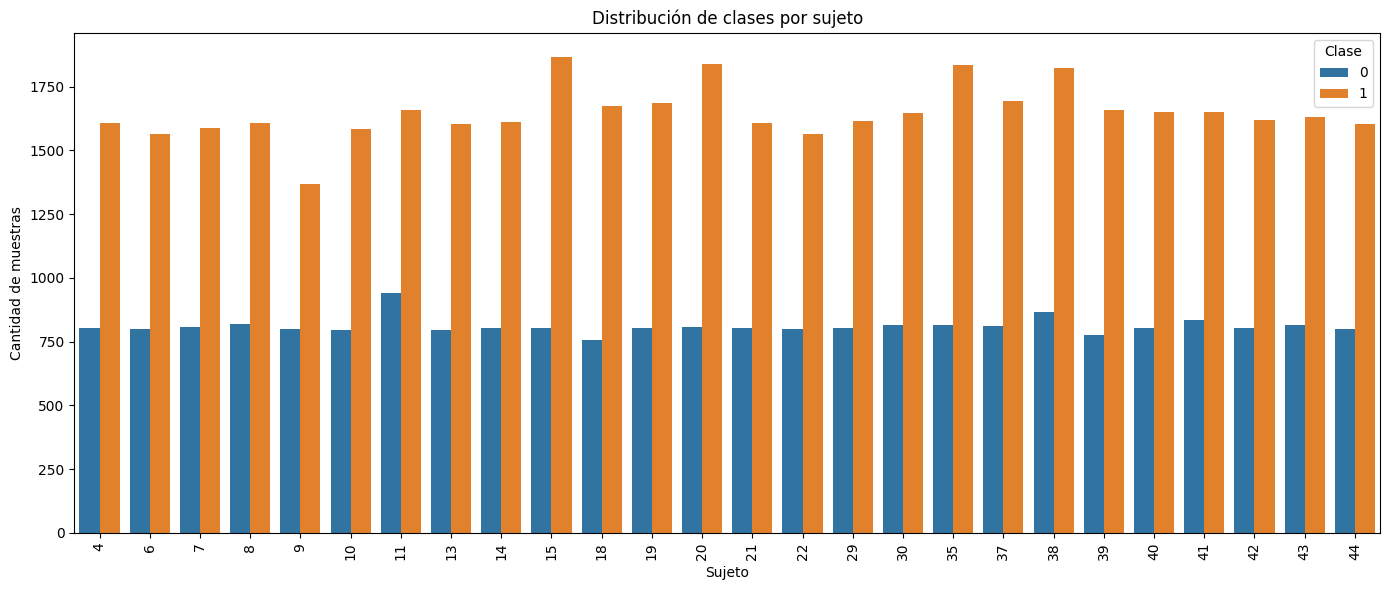

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar que son arrays 1D
subjects_flat = np.ravel(subjects_filtrados)
y_flat = np.ravel(y_filtrado)

# Crear DataFrame temporal para análisis
df_temp = pd.DataFrame({
    'subject': subjects_flat,
    'label': y_flat
})

# Contar clases por sujeto
counts = df_temp.groupby(['subject', 'label']).size().reset_index(name='count')

# Gráfico de barras
plt.figure(figsize=(14, 6))
sns.barplot(data=counts, x='subject', y='count', hue='label')
plt.title('Distribución de clases por sujeto')
plt.xlabel('Sujeto')
plt.ylabel('Cantidad de muestras')
plt.xticks(rotation=90)
plt.legend(title='Clase')
plt.tight_layout()
plt.show()


🧪 Validando grupo 1 de 37
📊 Distribución TRAIN: {0: 4024, 1: 8254}
📊 Distribución TEST: {0: 159, 1: 322}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.49
Clases en test (sujeto 1): {0: 159, 1: 322}
Epoch 1/50
384/384 [==============================] - 5s 5ms/step - loss: 0.6639 - accuracy: 0.5691 - val_loss: 0.6572 - val_accuracy: 0.5177

Epoch 00001: val_accuracy improved from -inf to 0.51767, saving model to modelos_cc_vs_str\mejor_modelo_1.h5
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 0.5584 - accuracy: 0.6842 - val_loss: 0.5489 - val_accuracy: 0.6840

Epoch 00002: val_accuracy improved from 0.51767 to 0.68399, saving model to modelos_cc_vs_str\mejor_modelo_1.h5
Epoch 3/50
384/384 [==============================] - 2s 4ms/step - loss: 0.4712 - accuracy: 0.7500 - val_loss: 0.4936 - val_accuracy: 0.7173

Epoch 00003: val_accuracy improved from 0.68399 to 0.71726, saving model to modelos_cc_vs_str\mejor_modelo_1.h5
Epoch 4/50
384/384 [=======================

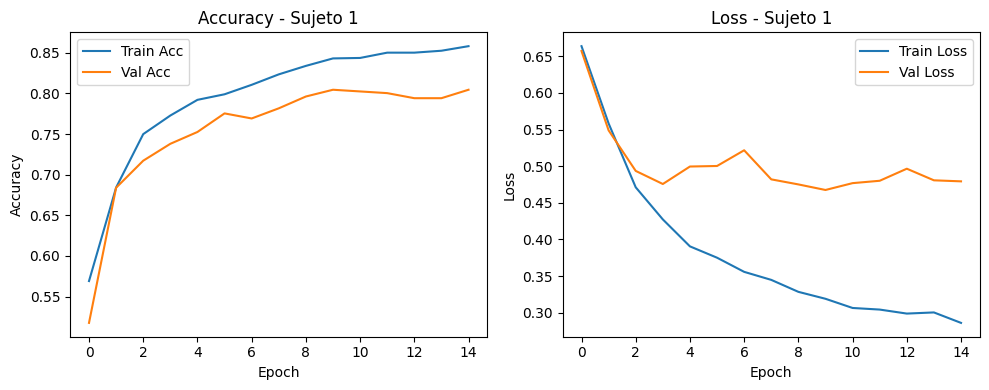

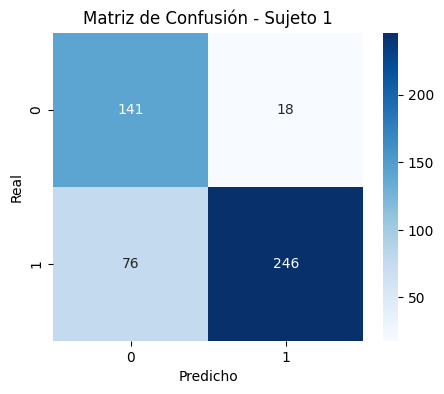

📄 Reporte de clasificación - Sujeto 1
              precision    recall  f1-score   support

           0     0.6498    0.8868    0.7500       159
           1     0.9318    0.7640    0.8396       322

    accuracy                         0.8046       481
   macro avg     0.7908    0.8254    0.7948       481
weighted avg     0.8386    0.8046    0.8100       481


🧪 Validando grupo 2 de 37
📊 Distribución TRAIN: {0: 4024, 1: 8263}
📊 Distribución TEST: {0: 159, 1: 313}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.51
Clases en test (sujeto 2): {0: 159, 1: 313}
Epoch 1/50
384/384 [==============================] - 4s 6ms/step - loss: 0.6195 - accuracy: 0.6198 - val_loss: 0.4621 - val_accuracy: 0.8178

Epoch 00001: val_accuracy improved from -inf to 0.81780, saving model to modelos_cc_vs_str\mejor_modelo_2.h5
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 0.5201 - accuracy: 0.6937 - val_loss: 0.3860 - val_accuracy: 0.8263

Epoch 00002: val_accuracy improved from 0.817

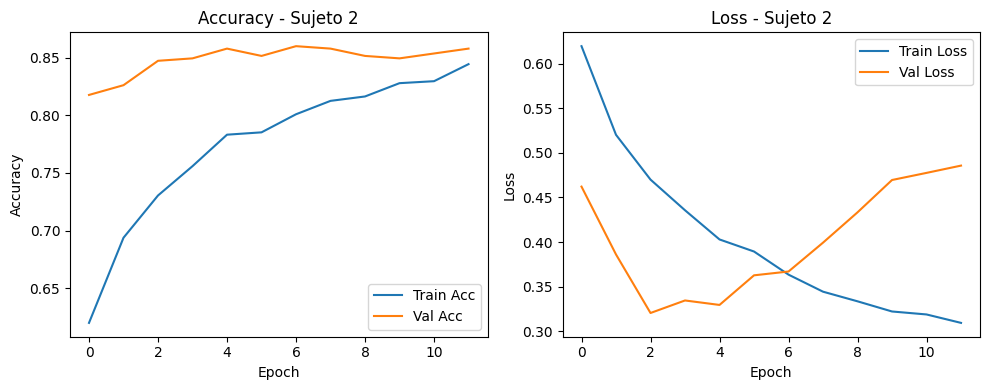

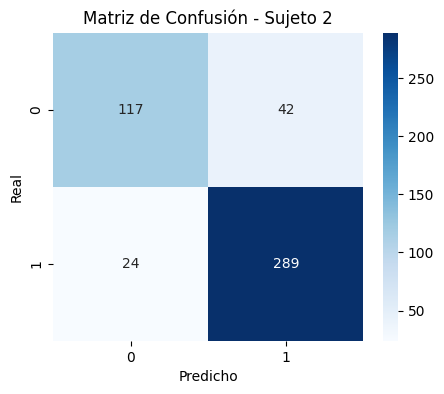

📄 Reporte de clasificación - Sujeto 2
              precision    recall  f1-score   support

           0     0.8298    0.7358    0.7800       159
           1     0.8731    0.9233    0.8975       313

    accuracy                         0.8602       472
   macro avg     0.8514    0.8296    0.8388       472
weighted avg     0.8585    0.8602    0.8579       472


🧪 Validando grupo 3 de 37
📊 Distribución TRAIN: {0: 4023, 1: 8259}
📊 Distribución TEST: {0: 160, 1: 317}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.50
Clases en test (sujeto 3): {0: 160, 1: 317}
Epoch 1/50
384/384 [==============================] - 4s 6ms/step - loss: 0.6568 - accuracy: 0.5936 - val_loss: 0.5147 - val_accuracy: 0.7820

Epoch 00001: val_accuracy improved from -inf to 0.78197, saving model to modelos_cc_vs_str\mejor_modelo_3.h5
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 0.5823 - accuracy: 0.6586 - val_loss: 0.4273 - val_accuracy: 0.7862

Epoch 00002: val_accuracy improved from 0.781

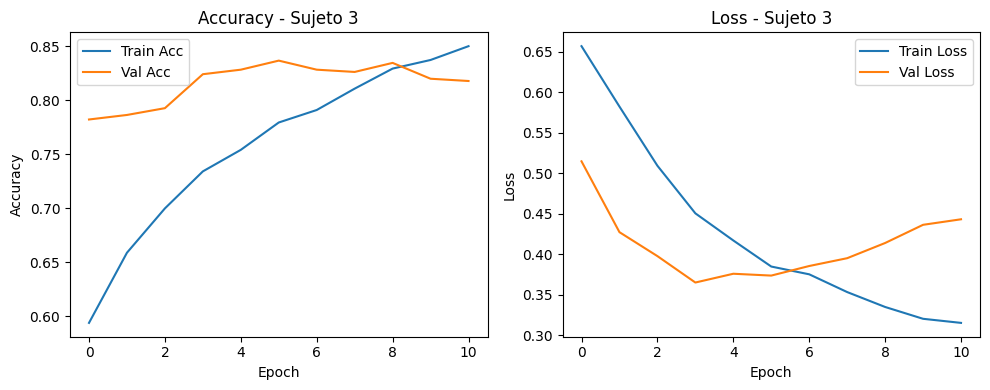

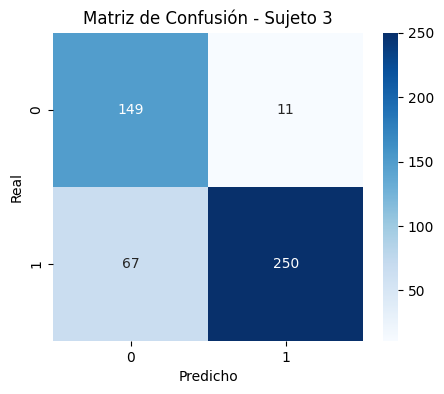

📄 Reporte de clasificación - Sujeto 3
              precision    recall  f1-score   support

           0     0.6898    0.9313    0.7926       160
           1     0.9579    0.7886    0.8651       317

    accuracy                         0.8365       477
   macro avg     0.8238    0.8599    0.8288       477
weighted avg     0.8679    0.8365    0.8407       477


🧪 Validando grupo 4 de 37
📊 Distribución TRAIN: {0: 4021, 1: 8254}
📊 Distribución TEST: {0: 162, 1: 322}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.50
Clases en test (sujeto 4): {0: 162, 1: 322}
Epoch 1/50
384/384 [==============================] - 4s 5ms/step - loss: 0.6472 - accuracy: 0.6465 - val_loss: 0.4798 - val_accuracy: 0.8719

Epoch 00001: val_accuracy improved from -inf to 0.87190, saving model to modelos_cc_vs_str\mejor_modelo_4.h5
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 0.5513 - accuracy: 0.7263 - val_loss: 0.3507 - val_accuracy: 0.8760

Epoch 00002: val_accuracy improved from 0.871

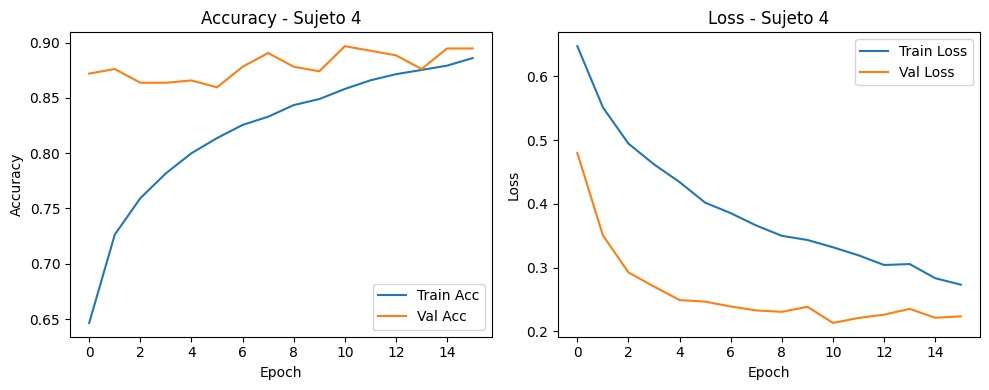

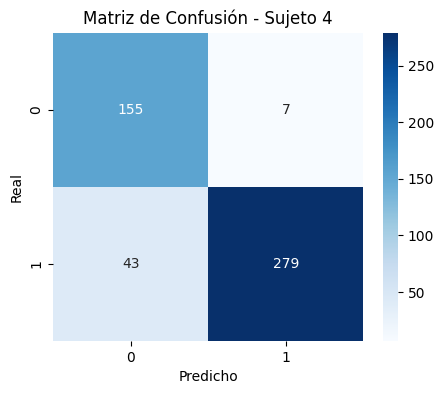

📄 Reporte de clasificación - Sujeto 4
              precision    recall  f1-score   support

           0     0.7828    0.9568    0.8611       162
           1     0.9755    0.8665    0.9178       322

    accuracy                         0.8967       484
   macro avg     0.8792    0.9116    0.8894       484
weighted avg     0.9110    0.8967    0.8988       484


🧪 Validando grupo 5 de 37
📊 Distribución TRAIN: {0: 4024, 1: 8302}
📊 Distribución TEST: {0: 159, 1: 274}
📊 Ratio Train (0/1): 0.48 | Test (0/1): 0.58
Clases en test (sujeto 5): {0: 159, 1: 274}
Epoch 1/50
386/386 [==============================] - 4s 6ms/step - loss: 0.6595 - accuracy: 0.6087 - val_loss: 0.5838 - val_accuracy: 0.8129

Epoch 00001: val_accuracy improved from -inf to 0.81293, saving model to modelos_cc_vs_str\mejor_modelo_5.h5
Epoch 2/50
386/386 [==============================] - 2s 4ms/step - loss: 0.5639 - accuracy: 0.7302 - val_loss: 0.3288 - val_accuracy: 0.9469

Epoch 00002: val_accuracy improved from 0.812

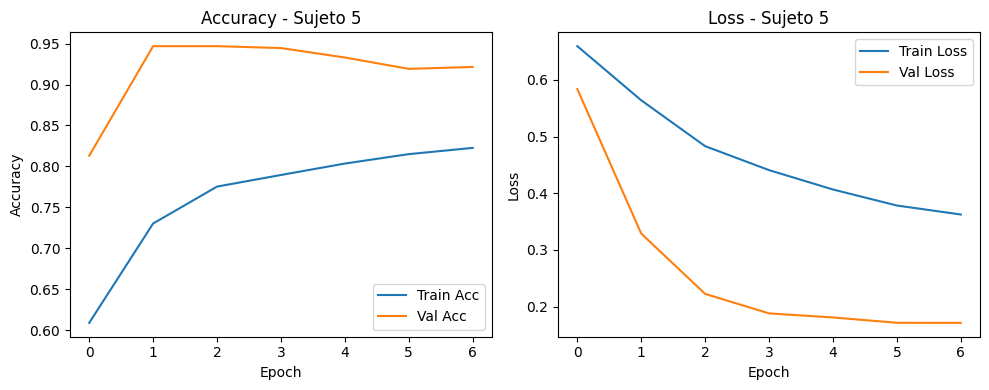

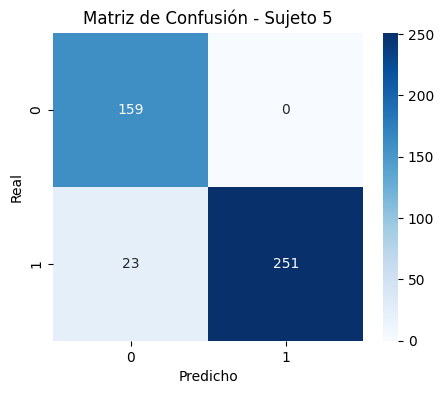

📄 Reporte de clasificación - Sujeto 5
              precision    recall  f1-score   support

           0     0.8736    1.0000    0.9326       159
           1     1.0000    0.9161    0.9562       274

    accuracy                         0.9469       433
   macro avg     0.9368    0.9580    0.9444       433
weighted avg     0.9536    0.9469    0.9475       433


🧪 Validando grupo 6 de 37
📊 Distribución TRAIN: {0: 4025, 1: 8259}
📊 Distribución TEST: {0: 158, 1: 317}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.50
Clases en test (sujeto 6): {0: 158, 1: 317}
Epoch 1/50
384/384 [==============================] - 4s 6ms/step - loss: 0.6542 - accuracy: 0.5868 - val_loss: 0.5860 - val_accuracy: 0.7200

Epoch 00001: val_accuracy improved from -inf to 0.72000, saving model to modelos_cc_vs_str\mejor_modelo_6.h5
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 0.5612 - accuracy: 0.7149 - val_loss: 0.5427 - val_accuracy: 0.7305

Epoch 00002: val_accuracy improved from 0.720

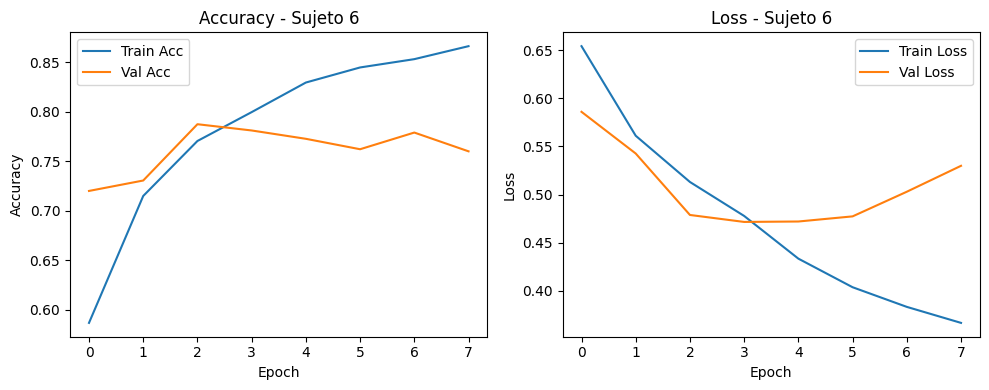

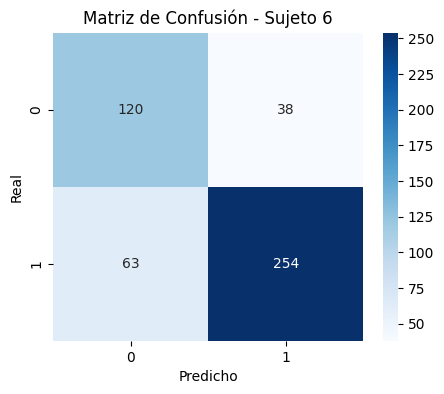

📄 Reporte de clasificación - Sujeto 6
              precision    recall  f1-score   support

           0     0.6557    0.7595    0.7038       158
           1     0.8699    0.8013    0.8342       317

    accuracy                         0.7874       475
   macro avg     0.7628    0.7804    0.7690       475
weighted avg     0.7986    0.7874    0.7908       475


🧪 Validando grupo 7 de 37
📊 Distribución TRAIN: {0: 3996, 1: 8244}
📊 Distribución TEST: {0: 187, 1: 332}
📊 Ratio Train (0/1): 0.48 | Test (0/1): 0.56
Clases en test (sujeto 7): {0: 187, 1: 332}
Epoch 1/50
383/383 [==============================] - 4s 6ms/step - loss: 0.6470 - accuracy: 0.6616 - val_loss: 0.4743 - val_accuracy: 0.8459

Epoch 00001: val_accuracy improved from -inf to 0.84586, saving model to modelos_cc_vs_str\mejor_modelo_7.h5
Epoch 2/50
383/383 [==============================] - 2s 4ms/step - loss: 0.5324 - accuracy: 0.7544 - val_loss: 0.3281 - val_accuracy: 0.8786

Epoch 00002: val_accuracy improved from 0.845

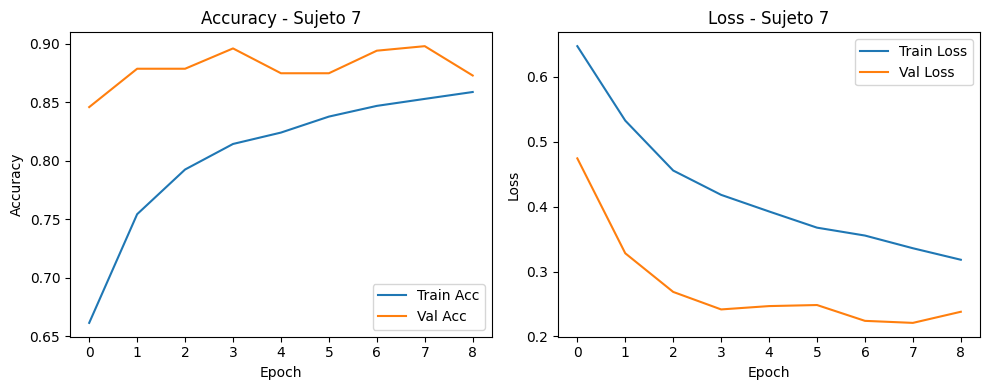

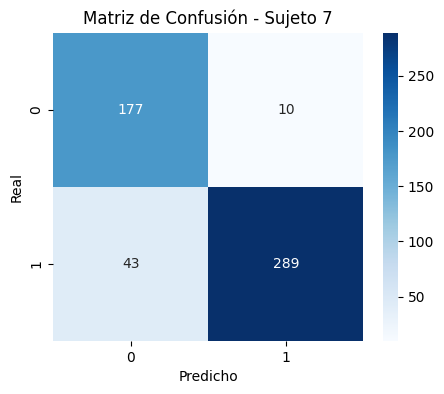

📄 Reporte de clasificación - Sujeto 7
              precision    recall  f1-score   support

           0     0.8045    0.9465    0.8698       187
           1     0.9666    0.8705    0.9160       332

    accuracy                         0.8979       519
   macro avg     0.8856    0.9085    0.8929       519
weighted avg     0.9082    0.8979    0.8994       519


🧪 Validando grupo 8 de 37
📊 Distribución TRAIN: {0: 4025, 1: 8255}
📊 Distribución TEST: {0: 158, 1: 321}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.49
Clases en test (sujeto 8): {0: 158, 1: 321}
Epoch 1/50
384/384 [==============================] - 4s 6ms/step - loss: 0.6383 - accuracy: 0.5976 - val_loss: 0.3997 - val_accuracy: 0.9061

Epoch 00001: val_accuracy improved from -inf to 0.90605, saving model to modelos_cc_vs_str\mejor_modelo_8.h5
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 0.5402 - accuracy: 0.6968 - val_loss: 0.2800 - val_accuracy: 0.9165

Epoch 00002: val_accuracy improved from 0.906

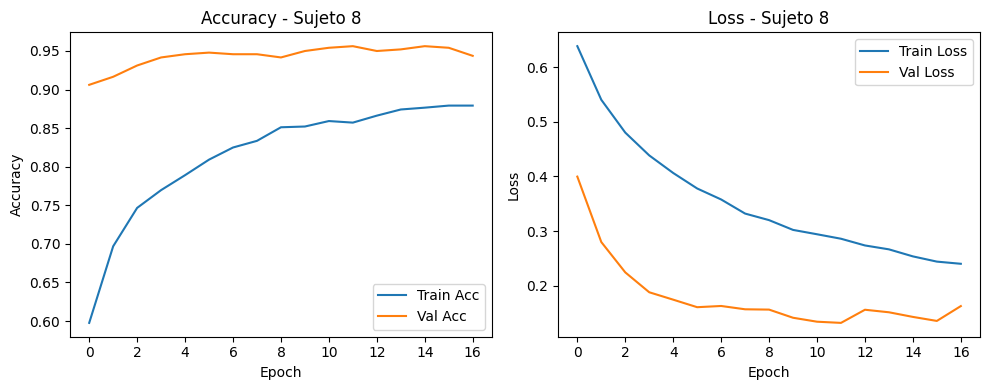

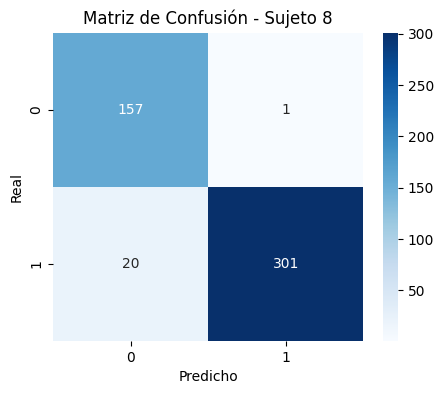

📄 Reporte de clasificación - Sujeto 8
              precision    recall  f1-score   support

           0     0.8870    0.9937    0.9373       158
           1     0.9967    0.9377    0.9663       321

    accuracy                         0.9562       479
   macro avg     0.9418    0.9657    0.9518       479
weighted avg     0.9605    0.9562    0.9567       479


🧪 Validando grupo 9 de 37
📊 Distribución TRAIN: {0: 4023, 1: 8254}
📊 Distribución TEST: {0: 160, 1: 322}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.50
Clases en test (sujeto 9): {0: 160, 1: 322}
Epoch 1/50
384/384 [==============================] - 4s 5ms/step - loss: 0.6497 - accuracy: 0.6314 - val_loss: 0.6016 - val_accuracy: 0.6846

Epoch 00001: val_accuracy improved from -inf to 0.68465, saving model to modelos_cc_vs_str\mejor_modelo_9.h5
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 0.5285 - accuracy: 0.7480 - val_loss: 0.5347 - val_accuracy: 0.6888

Epoch 00002: val_accuracy improved from 0.684

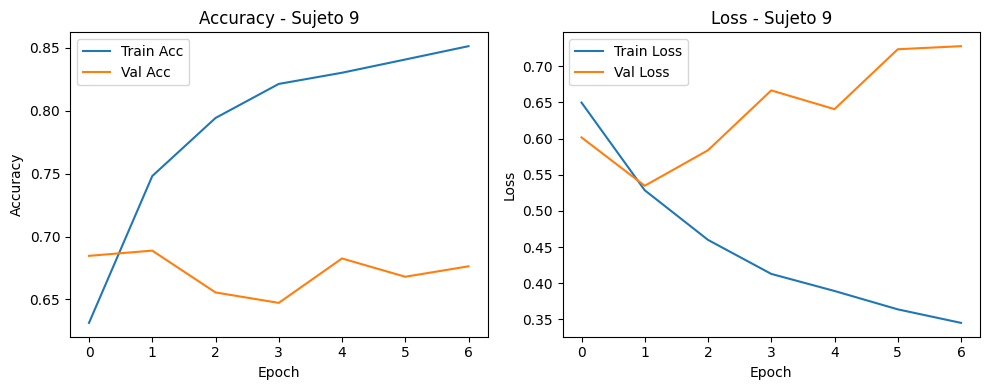

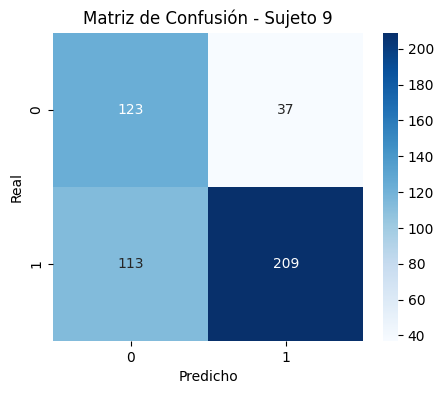

📄 Reporte de clasificación - Sujeto 9
              precision    recall  f1-score   support

           0     0.5212    0.7688    0.6212       160
           1     0.8496    0.6491    0.7359       322

    accuracy                         0.6888       482
   macro avg     0.6854    0.7089    0.6786       482
weighted avg     0.7406    0.6888    0.6978       482


🧪 Validando grupo 10 de 37
📊 Distribución TRAIN: {0: 4024, 1: 8202}
📊 Distribución TEST: {0: 159, 1: 374}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.43
Clases en test (sujeto 10): {0: 159, 1: 374}
Epoch 1/50
383/383 [==============================] - 4s 5ms/step - loss: 0.6465 - accuracy: 0.6121 - val_loss: 0.5199 - val_accuracy: 0.7261

Epoch 00001: val_accuracy improved from -inf to 0.72608, saving model to modelos_cc_vs_str\mejor_modelo_10.h5
Epoch 2/50
383/383 [==============================] - 2s 4ms/step - loss: 0.5368 - accuracy: 0.7252 - val_loss: 0.4383 - val_accuracy: 0.7692

Epoch 00002: val_accuracy improved from 0.

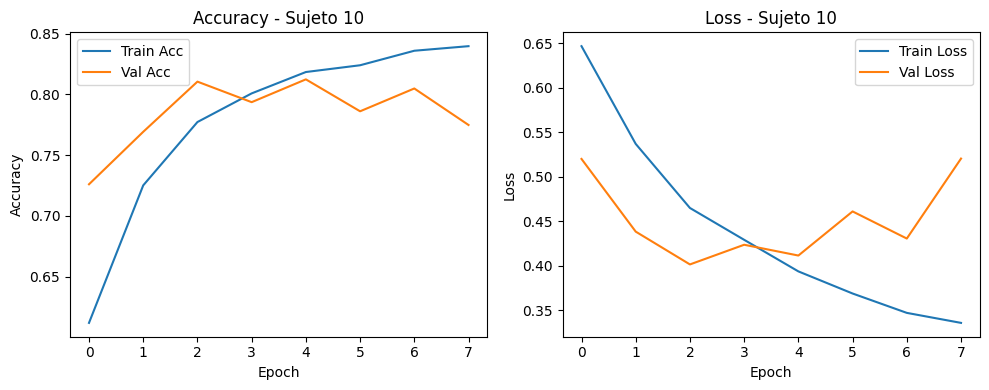

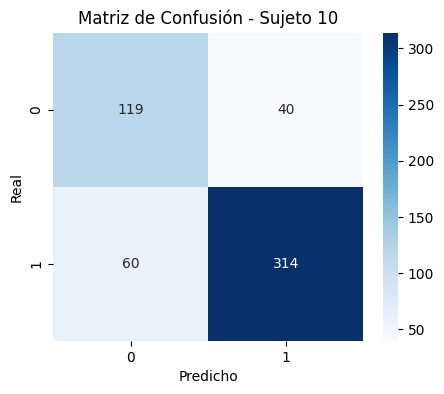

📄 Reporte de clasificación - Sujeto 10
              precision    recall  f1-score   support

           0     0.6648    0.7484    0.7041       159
           1     0.8870    0.8396    0.8626       374

    accuracy                         0.8124       533
   macro avg     0.7759    0.7940    0.7834       533
weighted avg     0.8207    0.8124    0.8154       533


🧪 Validando grupo 11 de 37
📊 Distribución TRAIN: {0: 4033, 1: 8241}
📊 Distribución TEST: {0: 150, 1: 335}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.45
Clases en test (sujeto 11): {0: 150, 1: 335}
Epoch 1/50
384/384 [==============================] - 4s 6ms/step - loss: 0.6427 - accuracy: 0.5894 - val_loss: 0.5513 - val_accuracy: 0.7629

Epoch 00001: val_accuracy improved from -inf to 0.76289, saving model to modelos_cc_vs_str\mejor_modelo_11.h5
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 0.5499 - accuracy: 0.7218 - val_loss: 0.4646 - val_accuracy: 0.8351

Epoch 00002: val_accuracy improved from 0

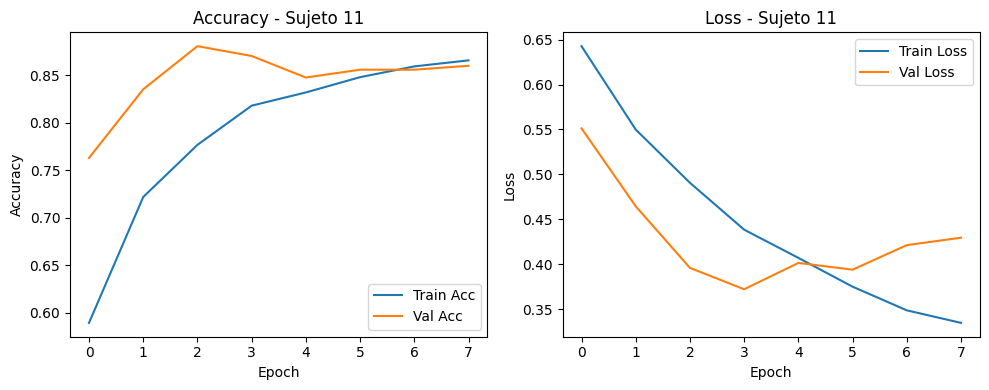

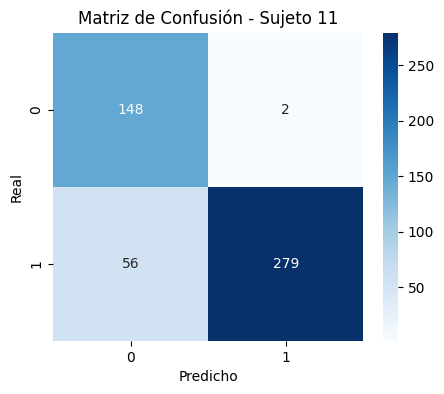

📄 Reporte de clasificación - Sujeto 11
              precision    recall  f1-score   support

           0     0.7255    0.9867    0.8362       150
           1     0.9929    0.8328    0.9058       335

    accuracy                         0.8804       485
   macro avg     0.8592    0.9098    0.8710       485
weighted avg     0.9102    0.8804    0.8843       485


🧪 Validando grupo 12 de 37
📊 Distribución TRAIN: {0: 4024, 1: 8239}
📊 Distribución TEST: {0: 159, 1: 337}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.47
Clases en test (sujeto 12): {0: 159, 1: 337}
Epoch 1/50
384/384 [==============================] - 4s 6ms/step - loss: 0.6487 - accuracy: 0.6332 - val_loss: 0.4521 - val_accuracy: 0.8548

Epoch 00001: val_accuracy improved from -inf to 0.85484, saving model to modelos_cc_vs_str\mejor_modelo_12.h5
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 0.5309 - accuracy: 0.7369 - val_loss: 0.2319 - val_accuracy: 0.9536

Epoch 00002: val_accuracy improved from 0

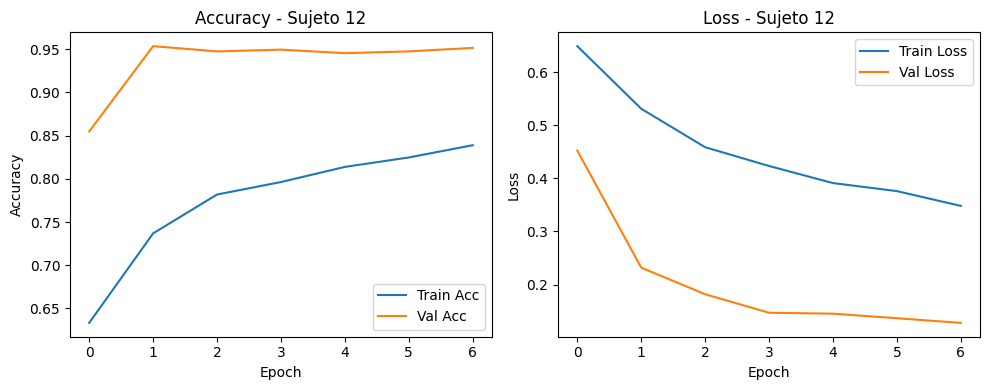

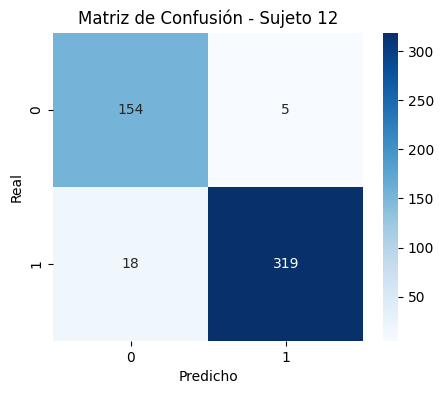

📄 Reporte de clasificación - Sujeto 12
              precision    recall  f1-score   support

           0     0.8953    0.9686    0.9305       159
           1     0.9846    0.9466    0.9652       337

    accuracy                         0.9536       496
   macro avg     0.9400    0.9576    0.9479       496
weighted avg     0.9560    0.9536    0.9541       496


🧪 Validando grupo 13 de 37
📊 Distribución TRAIN: {0: 4023, 1: 8208}
📊 Distribución TEST: {0: 160, 1: 368}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.43
Clases en test (sujeto 13): {0: 160, 1: 368}
Epoch 1/50
383/383 [==============================] - 4s 5ms/step - loss: 0.6499 - accuracy: 0.5671 - val_loss: 0.5194 - val_accuracy: 0.8182

Epoch 00001: val_accuracy improved from -inf to 0.81818, saving model to modelos_cc_vs_str\mejor_modelo_13.h5
Epoch 2/50
383/383 [==============================] - 2s 4ms/step - loss: 0.5338 - accuracy: 0.7290 - val_loss: 0.3619 - val_accuracy: 0.8731

Epoch 00002: val_accuracy improved from 0

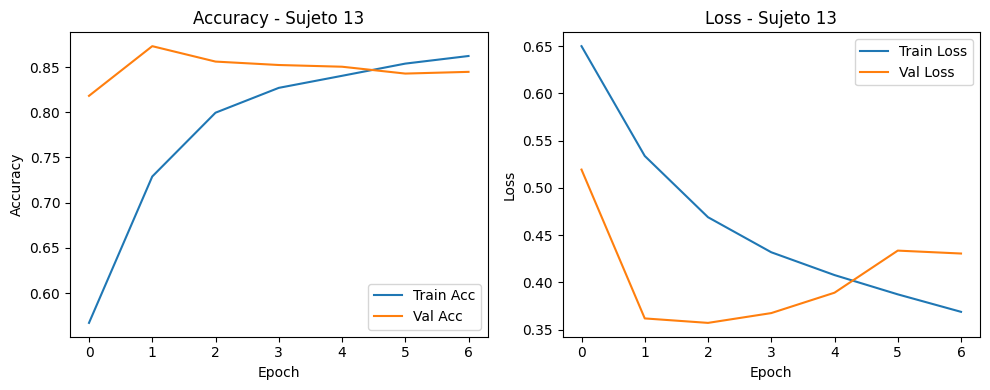

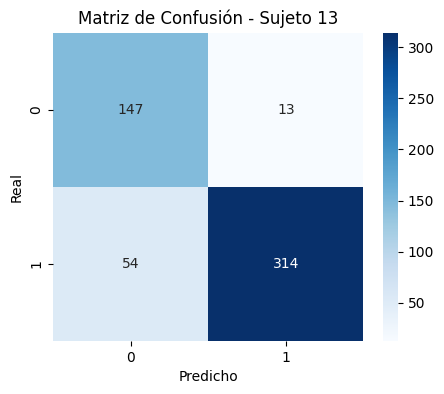

📄 Reporte de clasificación - Sujeto 13
              precision    recall  f1-score   support

           0     0.7313    0.9187    0.8144       160
           1     0.9602    0.8533    0.9036       368

    accuracy                         0.8731       528
   macro avg     0.8458    0.8860    0.8590       528
weighted avg     0.8909    0.8731    0.8766       528


🧪 Validando grupo 14 de 37
📊 Distribución TRAIN: {0: 4024, 1: 8254}
📊 Distribución TEST: {0: 159, 1: 322}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.49
Clases en test (sujeto 14): {0: 159, 1: 322}
Epoch 1/50
384/384 [==============================] - 4s 6ms/step - loss: 0.6656 - accuracy: 0.5383 - val_loss: 0.6461 - val_accuracy: 0.8025

Epoch 00001: val_accuracy improved from -inf to 0.80249, saving model to modelos_cc_vs_str\mejor_modelo_14.h5
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 0.5822 - accuracy: 0.7257 - val_loss: 0.5494 - val_accuracy: 0.8316

Epoch 00002: val_accuracy improved from 0

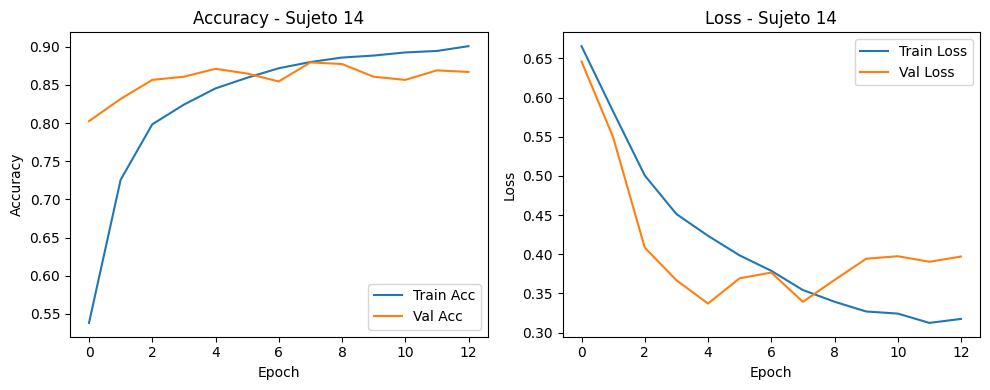

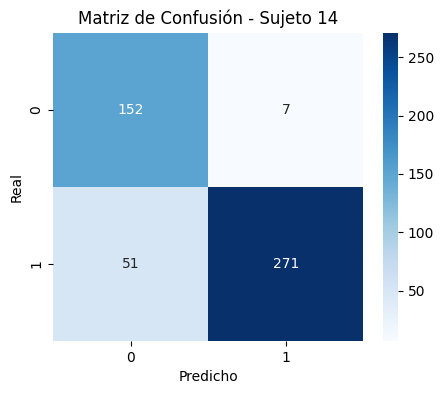

📄 Reporte de clasificación - Sujeto 14
              precision    recall  f1-score   support

           0     0.7488    0.9560    0.8398       159
           1     0.9748    0.8416    0.9033       322

    accuracy                         0.8794       481
   macro avg     0.8618    0.8988    0.8716       481
weighted avg     0.9001    0.8794    0.8823       481


🧪 Validando grupo 15 de 37
📊 Distribución TRAIN: {0: 4024, 1: 8263}
📊 Distribución TEST: {0: 159, 1: 313}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.51
Clases en test (sujeto 15): {0: 159, 1: 313}
Epoch 1/50
384/384 [==============================] - 4s 5ms/step - loss: 0.6324 - accuracy: 0.5491 - val_loss: 0.6582 - val_accuracy: 0.7839

Epoch 00001: val_accuracy improved from -inf to 0.78390, saving model to modelos_cc_vs_str\mejor_modelo_15.h5
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 0.5559 - accuracy: 0.7399 - val_loss: 0.6596 - val_accuracy: 0.7945

Epoch 00002: val_accuracy improved from 0

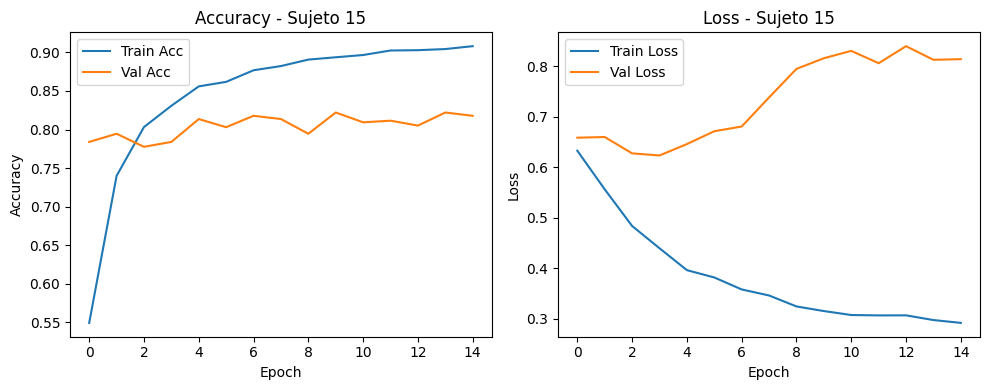

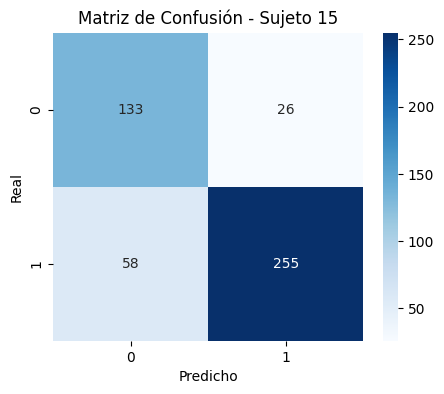

📄 Reporte de clasificación - Sujeto 15
              precision    recall  f1-score   support

           0     0.6963    0.8365    0.7600       159
           1     0.9075    0.8147    0.8586       313

    accuracy                         0.8220       472
   macro avg     0.8019    0.8256    0.8093       472
weighted avg     0.8363    0.8220    0.8254       472


🧪 Validando grupo 16 de 37
📊 Distribución TRAIN: {0: 4024, 1: 8252}
📊 Distribución TEST: {0: 159, 1: 324}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.49
🔧 Sujeto 16: Ajuste MODERADO class_weight (test_ratio: 0.49)
Clases en test (sujeto 16): {0: 159, 1: 324}
Epoch 1/50
192/192 [==============================] - 3s 8ms/step - loss: 0.8243 - accuracy: 0.5910 - val_loss: 0.6046 - val_accuracy: 0.6377

Epoch 00001: val_accuracy improved from -inf to 0.63768, saving model to modelos_cc_vs_str\mejor_modelo_16.h5
Epoch 2/50
192/192 [==============================] - 1s 4ms/step - loss: 0.6950 - accuracy: 0.7234 - val_loss: 0.5745 - va

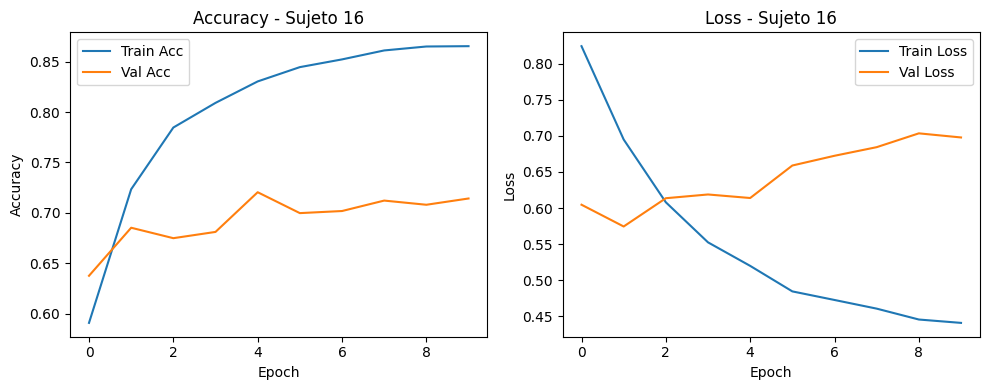

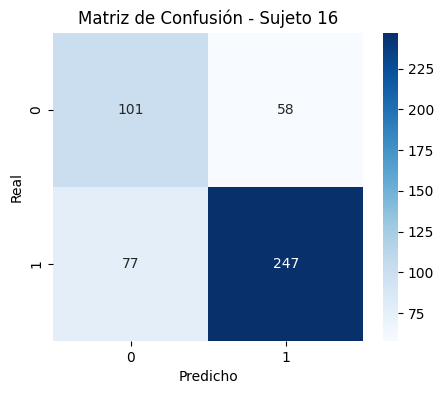

📄 Reporte de clasificación - Sujeto 16
              precision    recall  f1-score   support

           0     0.5674    0.6352    0.5994       159
           1     0.8098    0.7623    0.7854       324

    accuracy                         0.7205       483
   macro avg     0.6886    0.6988    0.6924       483
weighted avg     0.7300    0.7205    0.7242       483


🧪 Validando grupo 17 de 37
📊 Distribución TRAIN: {0: 4021, 1: 8247}
📊 Distribución TEST: {0: 162, 1: 329}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.49
🔧 Sujeto 17: Ajuste MODERADO class_weight (test_ratio: 0.49)
Clases en test (sujeto 17): {0: 162, 1: 329}
Epoch 1/50
192/192 [==============================] - 3s 7ms/step - loss: 0.8538 - accuracy: 0.5567 - val_loss: 0.6555 - val_accuracy: 0.6619

Epoch 00001: val_accuracy improved from -inf to 0.66191, saving model to modelos_cc_vs_str\mejor_modelo_17.h5
Epoch 2/50
192/192 [==============================] - 1s 4ms/step - loss: 0.7637 - accuracy: 0.7152 - val_loss: 0.6171 - va

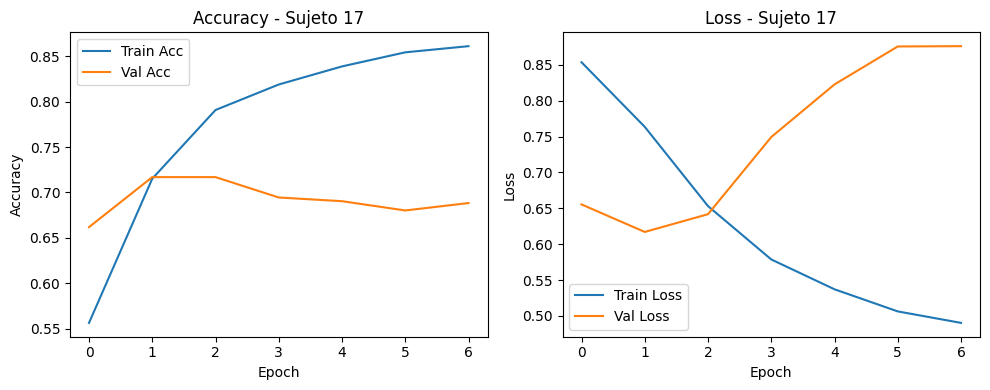

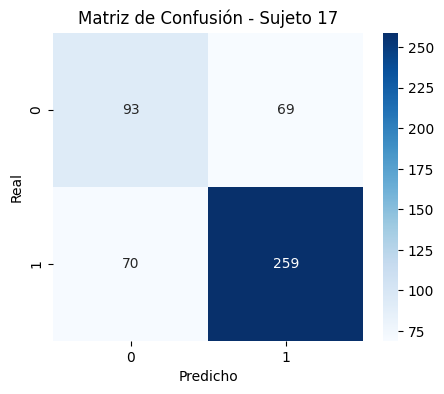

📄 Reporte de clasificación - Sujeto 17
              precision    recall  f1-score   support

           0     0.5706    0.5741    0.5723       162
           1     0.7896    0.7872    0.7884       329

    accuracy                         0.7169       491
   macro avg     0.6801    0.6807    0.6804       491
weighted avg     0.7174    0.7169    0.7171       491


🧪 Validando grupo 18 de 37
📊 Distribución TRAIN: {0: 4021, 1: 8209}
📊 Distribución TEST: {0: 162, 1: 367}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.44
🔧 Sujeto 18: Ajuste MODERADO class_weight (test_ratio: 0.44)
Clases en test (sujeto 18): {0: 162, 1: 367}
Epoch 1/50
192/192 [==============================] - 3s 8ms/step - loss: 0.8579 - accuracy: 0.5553 - val_loss: 0.6567 - val_accuracy: 0.7353

Epoch 00001: val_accuracy improved from -inf to 0.73535, saving model to modelos_cc_vs_str\mejor_modelo_18.h5
Epoch 2/50
192/192 [==============================] - 1s 4ms/step - loss: 0.7974 - accuracy: 0.6859 - val_loss: 0.5874 - va

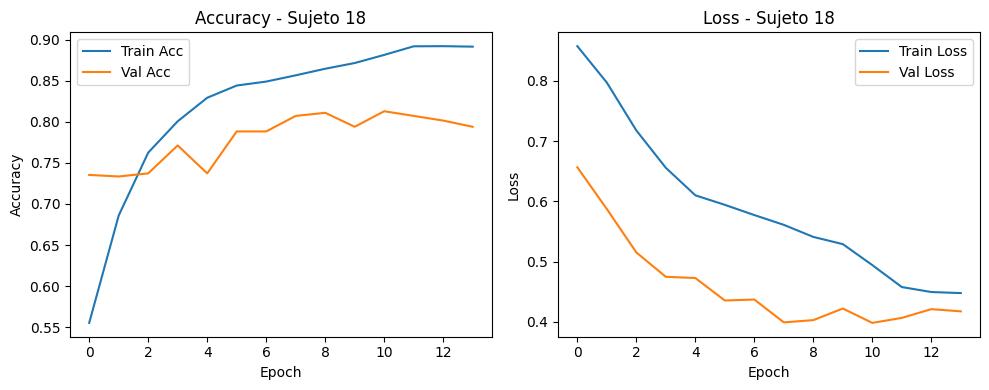

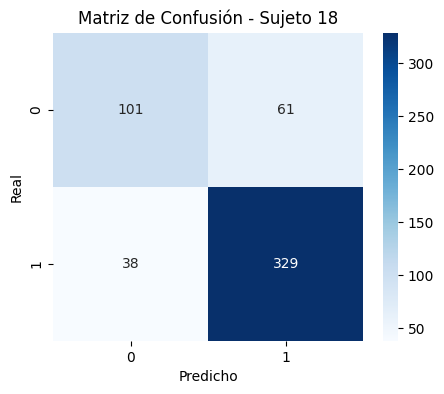

📄 Reporte de clasificación - Sujeto 18
              precision    recall  f1-score   support

           0     0.7266    0.6235    0.6711       162
           1     0.8436    0.8965    0.8692       367

    accuracy                         0.8129       529
   macro avg     0.7851    0.7600    0.7702       529
weighted avg     0.8078    0.8129    0.8085       529


🧪 Validando grupo 19 de 37
📊 Distribución TRAIN: {0: 4022, 1: 8237}
📊 Distribución TEST: {0: 161, 1: 339}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.47
🔧 Sujeto 19: Ajuste MODERADO class_weight (test_ratio: 0.47)
Clases en test (sujeto 19): {0: 161, 1: 339}
Epoch 1/50
192/192 [==============================] - 3s 7ms/step - loss: 0.8453 - accuracy: 0.5803 - val_loss: 0.6346 - val_accuracy: 0.7020

Epoch 00001: val_accuracy improved from -inf to 0.70200, saving model to modelos_cc_vs_str\mejor_modelo_19.h5
Epoch 2/50
192/192 [==============================] - 1s 4ms/step - loss: 0.7540 - accuracy: 0.6771 - val_loss: 0.5787 - va

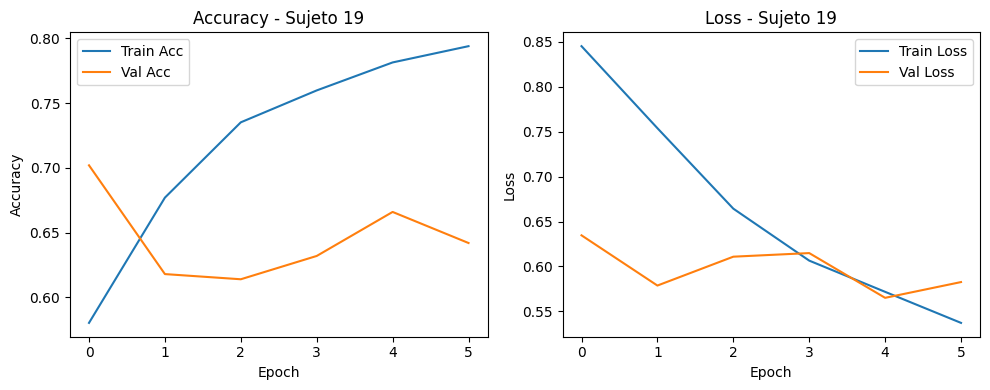

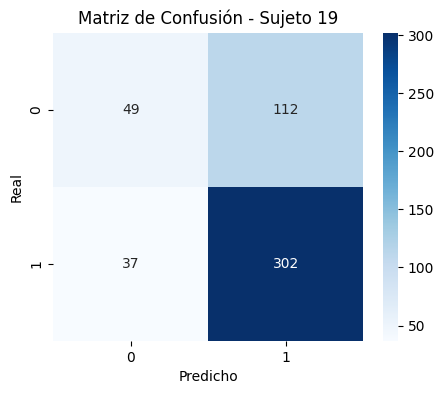

📄 Reporte de clasificación - Sujeto 19
              precision    recall  f1-score   support

           0     0.5698    0.3043    0.3968       161
           1     0.7295    0.8909    0.8021       339

    accuracy                         0.7020       500
   macro avg     0.6496    0.5976    0.5994       500
weighted avg     0.6780    0.7020    0.6716       500


🧪 Validando grupo 20 de 37
📊 Distribución TRAIN: {0: 4011, 1: 8211}
📊 Distribución TEST: {0: 172, 1: 365}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.47
🔧 Sujeto 20: Ajuste MODERADO class_weight (test_ratio: 0.47)
Clases en test (sujeto 20): {0: 172, 1: 365}
Epoch 1/50
191/191 [==============================] - 3s 8ms/step - loss: 0.8562 - accuracy: 0.5983 - val_loss: 0.6323 - val_accuracy: 0.8752

Epoch 00001: val_accuracy improved from -inf to 0.87523, saving model to modelos_cc_vs_str\mejor_modelo_20.h5
Epoch 2/50
191/191 [==============================] - 1s 4ms/step - loss: 0.7822 - accuracy: 0.6978 - val_loss: 0.4843 - va

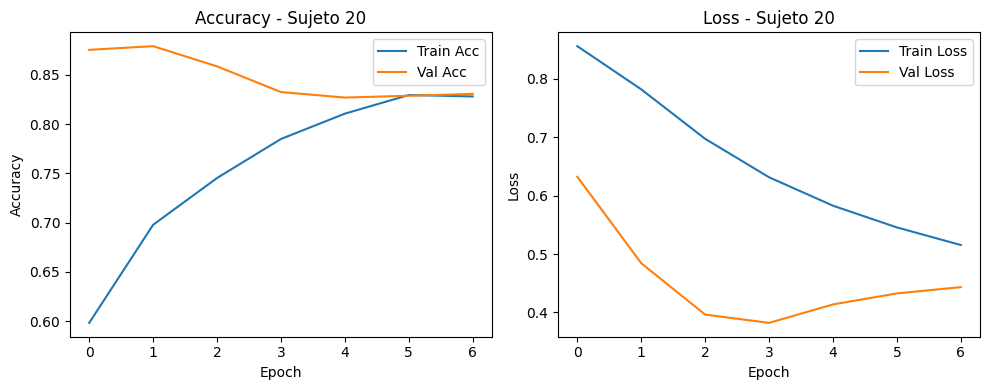

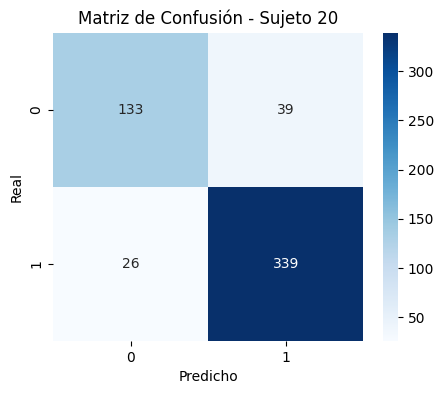

📄 Reporte de clasificación - Sujeto 20
              precision    recall  f1-score   support

           0     0.8365    0.7733    0.8036       172
           1     0.8968    0.9288    0.9125       365

    accuracy                         0.8790       537
   macro avg     0.8667    0.8510    0.8581       537
weighted avg     0.8775    0.8790    0.8776       537


🧪 Validando grupo 21 de 37
📊 Distribución TRAIN: {0: 4029, 1: 8244}
📊 Distribución TEST: {0: 154, 1: 332}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.46
🔧 Sujeto 21: Ajuste MODERADO class_weight (test_ratio: 0.46)
Clases en test (sujeto 21): {0: 154, 1: 332}
Epoch 1/50
192/192 [==============================] - 3s 6ms/step - loss: 0.8301 - accuracy: 0.6394 - val_loss: 0.5979 - val_accuracy: 0.7675

Epoch 00001: val_accuracy improved from -inf to 0.76749, saving model to modelos_cc_vs_str\mejor_modelo_21.h5
Epoch 2/50
192/192 [==============================] - 1s 4ms/step - loss: 0.7391 - accuracy: 0.7103 - val_loss: 0.4853 - va

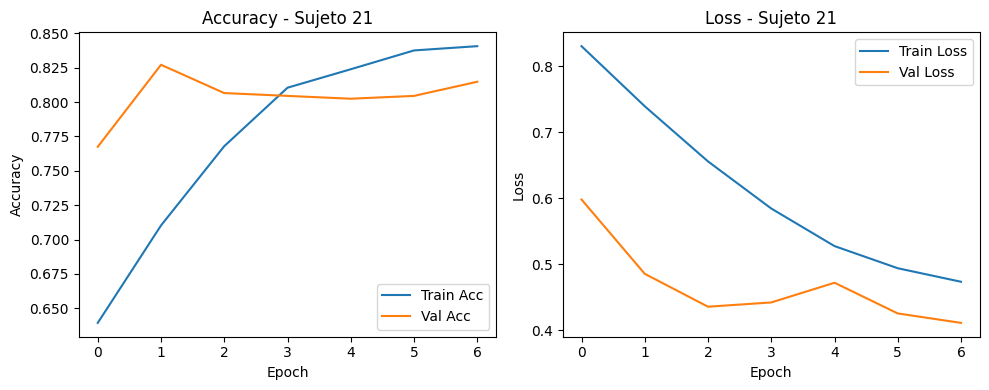

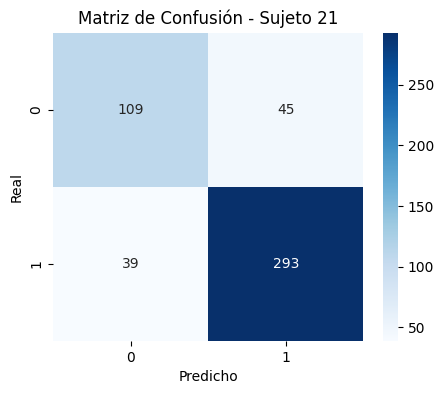

📄 Reporte de clasificación - Sujeto 21
              precision    recall  f1-score   support

           0     0.7365    0.7078    0.7219       154
           1     0.8669    0.8825    0.8746       332

    accuracy                         0.8272       486
   macro avg     0.8017    0.7952    0.7982       486
weighted avg     0.8256    0.8272    0.8262       486


🧪 Validando grupo 22 de 37
📊 Distribución TRAIN: {0: 4024, 1: 8246}
📊 Distribución TEST: {0: 159, 1: 330}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.48
🔧 Sujeto 22: Ajuste MODERADO class_weight (test_ratio: 0.48)
Clases en test (sujeto 22): {0: 159, 1: 330}
Epoch 1/50
192/192 [==============================] - 3s 8ms/step - loss: 0.8418 - accuracy: 0.5478 - val_loss: 0.5992 - val_accuracy: 0.7751

Epoch 00001: val_accuracy improved from -inf to 0.77505, saving model to modelos_cc_vs_str\mejor_modelo_22.h5
Epoch 2/50
192/192 [==============================] - 1s 4ms/step - loss: 0.7625 - accuracy: 0.6425 - val_loss: 0.5042 - va

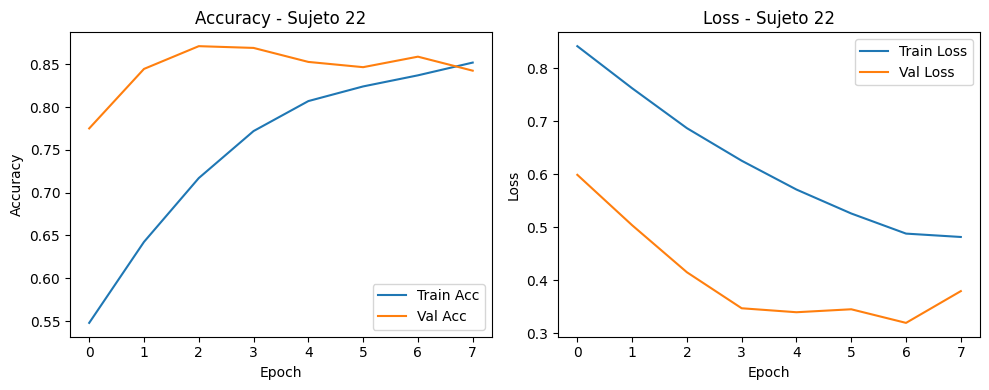

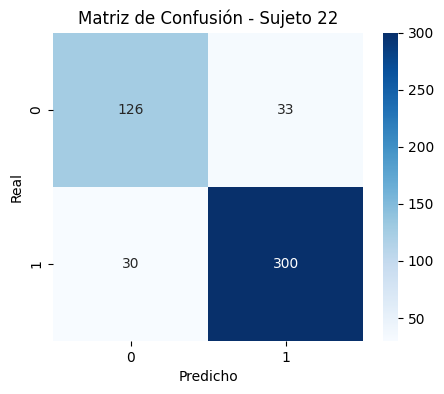

📄 Reporte de clasificación - Sujeto 22
              precision    recall  f1-score   support

           0     0.8077    0.7925    0.8000       159
           1     0.9009    0.9091    0.9050       330

    accuracy                         0.8712       489
   macro avg     0.8543    0.8508    0.8525       489
weighted avg     0.8706    0.8712    0.8708       489


🧪 Validando grupo 23 de 37
📊 Distribución TRAIN: {0: 4017, 1: 8246}
📊 Distribución TEST: {0: 166, 1: 330}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.50
🔧 Sujeto 23: Ajuste MODERADO class_weight (test_ratio: 0.50)
Clases en test (sujeto 23): {0: 166, 1: 330}
Epoch 1/50
192/192 [==============================] - 3s 8ms/step - loss: 0.8304 - accuracy: 0.6265 - val_loss: 0.6122 - val_accuracy: 0.6694

Epoch 00001: val_accuracy improved from -inf to 0.66935, saving model to modelos_cc_vs_str\mejor_modelo_23.h5
Epoch 2/50
192/192 [==============================] - 1s 4ms/step - loss: 0.7099 - accuracy: 0.6833 - val_loss: 0.6140 - va

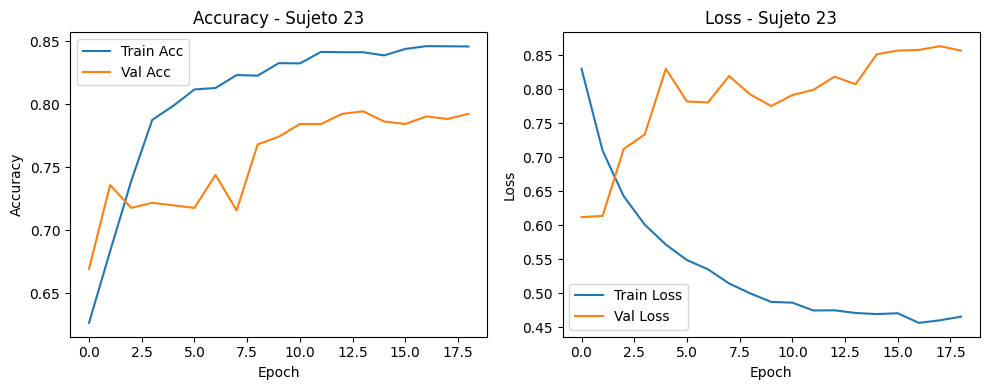

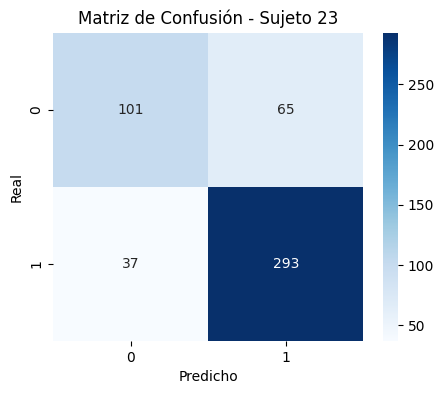

📄 Reporte de clasificación - Sujeto 23
              precision    recall  f1-score   support

           0     0.7319    0.6084    0.6645       166
           1     0.8184    0.8879    0.8517       330

    accuracy                         0.7944       496
   macro avg     0.7752    0.7482    0.7581       496
weighted avg     0.7895    0.7944    0.7891       496


🧪 Validando grupo 24 de 37
📊 Distribución TRAIN: {0: 4024, 1: 8252}
📊 Distribución TEST: {0: 159, 1: 324}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.49
🔧 Sujeto 24: Ajuste MODERADO class_weight (test_ratio: 0.49)
Clases en test (sujeto 24): {0: 159, 1: 324}
Epoch 1/50
192/192 [==============================] - 3s 7ms/step - loss: 0.8477 - accuracy: 0.5847 - val_loss: 0.6920 - val_accuracy: 0.6542

Epoch 00001: val_accuracy improved from -inf to 0.65424, saving model to modelos_cc_vs_str\mejor_modelo_24.h5
Epoch 2/50
192/192 [==============================] - 1s 4ms/step - loss: 0.7601 - accuracy: 0.7110 - val_loss: 0.6124 - va

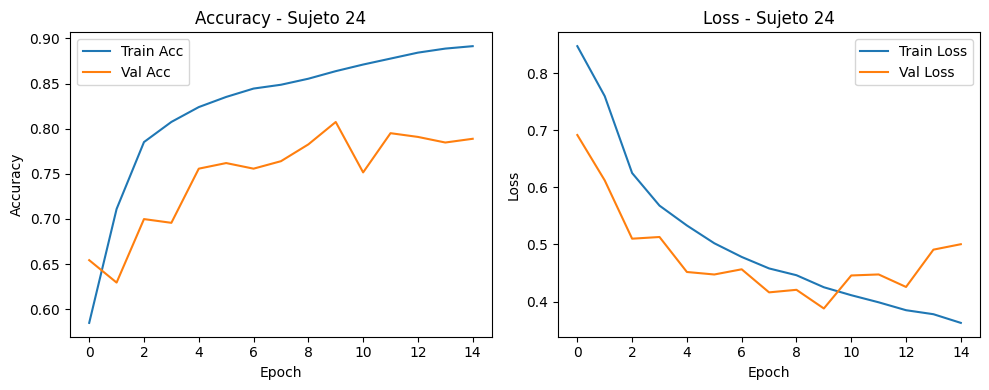

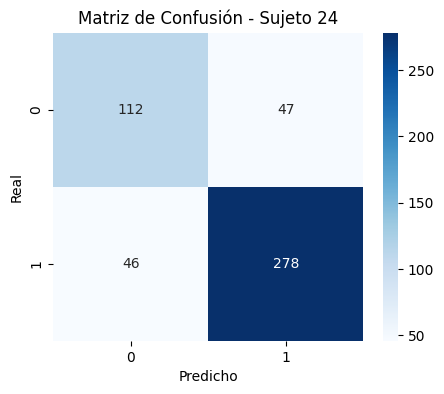

📄 Reporte de clasificación - Sujeto 24
              precision    recall  f1-score   support

           0     0.7089    0.7044    0.7066       159
           1     0.8554    0.8580    0.8567       324

    accuracy                         0.8075       483
   macro avg     0.7821    0.7812    0.7817       483
weighted avg     0.8072    0.8075    0.8073       483


🧪 Validando grupo 25 de 37
📊 Distribución TRAIN: {0: 4021, 1: 8250}
📊 Distribución TEST: {0: 162, 1: 326}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.50
🔧 Sujeto 25: Ajuste MODERADO class_weight (test_ratio: 0.50)
Clases en test (sujeto 25): {0: 162, 1: 326}
Epoch 1/50
192/192 [==============================] - 3s 8ms/step - loss: 0.7931 - accuracy: 0.6617 - val_loss: 0.4899 - val_accuracy: 0.6701

Epoch 00001: val_accuracy improved from -inf to 0.67008, saving model to modelos_cc_vs_str\mejor_modelo_25.h5
Epoch 2/50
192/192 [==============================] - 1s 4ms/step - loss: 0.6959 - accuracy: 0.6974 - val_loss: 0.3947 - va

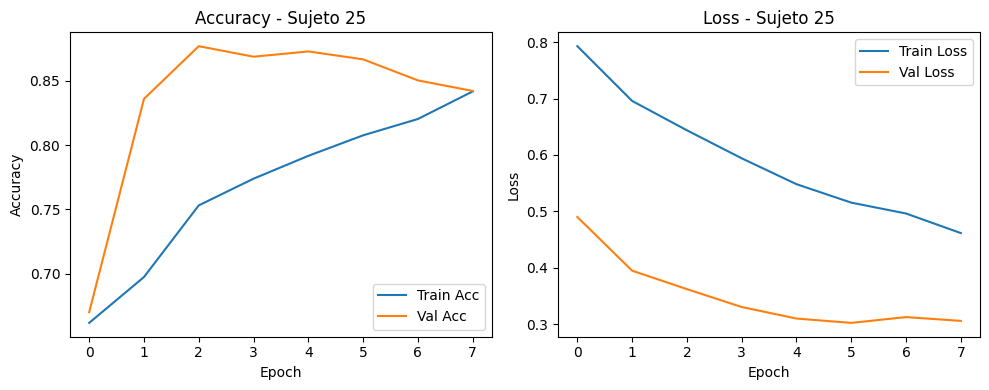

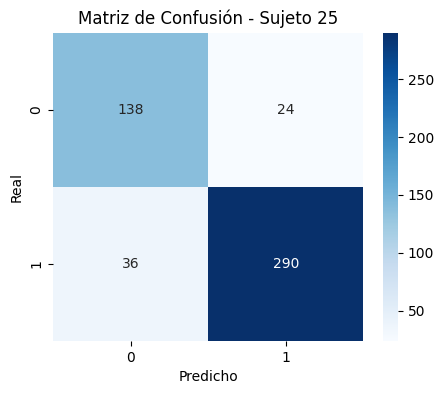

📄 Reporte de clasificación - Sujeto 25
              precision    recall  f1-score   support

           0     0.7931    0.8519    0.8214       162
           1     0.9236    0.8896    0.9062       326

    accuracy                         0.8770       488
   macro avg     0.8583    0.8707    0.8638       488
weighted avg     0.8803    0.8770    0.8781       488


🧪 Validando grupo 26 de 37
📊 Distribución TRAIN: {0: 4024, 1: 8255}
📊 Distribución TEST: {0: 159, 1: 321}
📊 Ratio Train (0/1): 0.49 | Test (0/1): 0.50
🔧 Sujeto 26: Ajuste MODERADO class_weight (test_ratio: 0.50)
Clases en test (sujeto 26): {0: 159, 1: 321}
Epoch 1/50
192/192 [==============================] - 3s 7ms/step - loss: 0.8124 - accuracy: 0.6229 - val_loss: 0.5700 - val_accuracy: 0.6979

Epoch 00001: val_accuracy improved from -inf to 0.69792, saving model to modelos_cc_vs_str\mejor_modelo_26.h5
Epoch 2/50
192/192 [==============================] - 1s 4ms/step - loss: 0.7205 - accuracy: 0.6883 - val_loss: 0.4825 - va

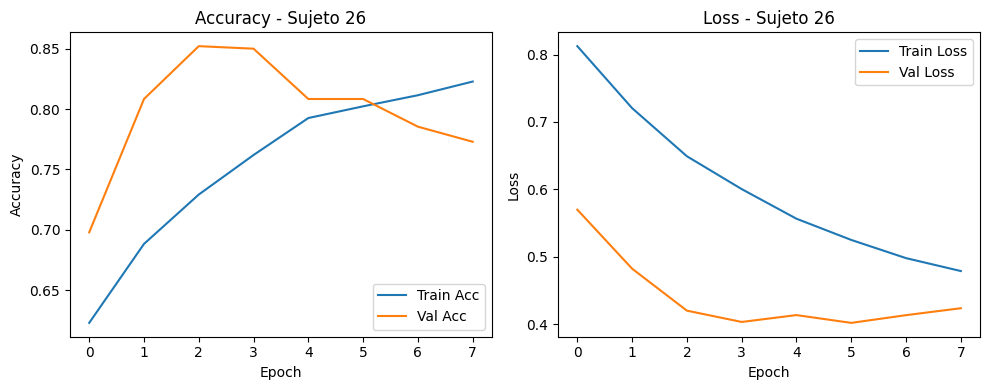

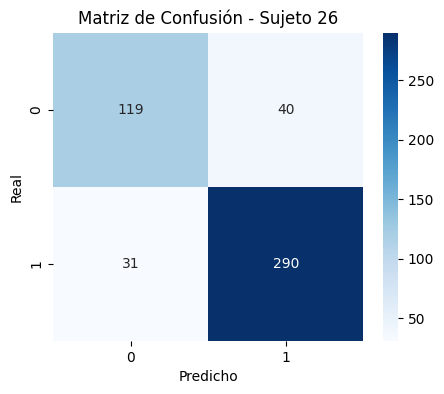

📄 Reporte de clasificación - Sujeto 26
              precision    recall  f1-score   support

           0     0.7933    0.7484    0.7702       159
           1     0.8788    0.9034    0.8909       321

    accuracy                         0.8521       480
   macro avg     0.8361    0.8259    0.8306       480
weighted avg     0.8505    0.8521    0.8510       480


📊 Resultados Finales:
Promedio Accuracy: 0.8368 ± 0.0716
Promedio F1 Score: 0.8758 ± 0.0547

🔍 Análisis Train vs Val:
Diferencia promedio (Val - Train): -0.0415 ± 0.0744
Folds donde Val > Train: 8/26


In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Bidirectional, Input

accuracies = []
f1_scores = []
train_val_diffs = []  # 🆕 Para analizar diferencias

logo = LeaveOneGroupOut()
split_num = 1

for train_idx, test_idx in logo.split(X_seq, y_seq, groups=subj_seq):

    set_seeds(42 + split_num)

    print(f"\n🧪 Validando grupo {split_num} de {len(np.unique(subjects))}")
    X_train, X_test = X_seq[train_idx], X_seq[test_idx]
    y_train, y_test = y_seq[train_idx], y_seq[test_idx]

    # 🔍 DIAGNÓSTICO: Verificar distribución de clases
    train_unique, train_counts = np.unique(y_train, return_counts=True)
    test_unique, test_counts = np.unique(y_test, return_counts=True)

    print(f"📊 Distribución TRAIN: {dict(zip(train_unique, train_counts))}")
    print(f"📊 Distribución TEST: {dict(zip(test_unique, test_counts))}")

    train_ratio = train_counts[0] / train_counts[1] if len(train_counts) > 1 else 1
    test_ratio = test_counts[0] / test_counts[1] if len(test_counts) > 1 else 1

    print(f"📊 Ratio Train (0/1): {train_ratio:.2f} | Test (0/1): {test_ratio:.2f}")

    if abs(train_ratio - test_ratio) > 0.5:
        print(f"⚠️  ALERTA: Distribuciones muy diferentes entre train y test!")

    X_train = tf.cast(X_train, tf.float32)
    X_test = tf.cast(X_test, tf.float32)
    y_train = tf.cast(y_train, tf.int32)
    y_test = tf.cast(y_test, tf.int32)


    checkpoint = ModelCheckpoint(f"modelos_cc_vs_str/mejor_modelo_{split_num}.h5", 
                                monitor="val_accuracy", 
                                save_best_only=True, 
                                verbose=1)

    early_stop = EarlyStopping(monitor="val_accuracy",  # ← Cambiar a val_accuracy
                            patience=5,         # ← 8 → 5 (más sensible)
                            restore_best_weights=True,
                            mode='max',         # ← min → max para accuracy
                            min_delta=0.002,    # ← 0.004 → 0.002 (más sensible)
                            verbose=1)

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                factor=0.5,        # ← 0.5 → 0.3 (más agresivo)
                                patience=4,         # ← Ya optimizado
                                min_lr=5e-6,       # ← 1e-7 → 5e-6 (limite más alto)
                                verbose=1,
                                mode='min',
                                min_delta=0.002) 
    
    # 🆕 ÚNICA MEJORA NECESARIA: Ajuste dinámico de class_weights
    class_weight_dict = calculate_optimal_class_weight(y_train.numpy(), y_test.numpy(), split_num)

        # 🆕 BATCH SIZE también dinámico basado en distribución
    train_counts = np.bincount(y_train.numpy())
    test_counts = np.bincount(y_test.numpy())
    total_samples = len(y_train)
    
    if 16 <= split_num <= 30:  # Sujetos con mucha data
        batch_size = 64  # Batch más grande para estabilidad
    elif total_samples < 1000:  # Sujetos con poca data
        batch_size = 16  # Batch más pequeño para mejor gradientes
    else:
        batch_size = 32  # Default

    unique, counts = np.unique(y_test, return_counts=True)
    print(f"Clases en test (sujeto {split_num}): {dict(zip(unique, counts))}")

    # 🔄 Modelo OPTIMIZADO - Versión mejorada
    model = Sequential([
        # Arquitectura más estable
        LSTM(64, dropout=0.25, return_sequences=True, input_shape=(10, 52)),  # ← Tamaño intermedio
        Dropout(0.25),
        
        LSTM(32, dropout=0.25),  # ← Más estable
        Dropout(0.3),
        
        # Clasificador conservativo
        Dense(16, activation='relu'),
        Dropout(0.4),
        Dense(8, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    with tf.device('/GPU:0'):
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=batch_size,
            validation_data=(X_test, y_test),
            callbacks=[checkpoint, reduce_lr, early_stop],
            class_weight=class_weight_dict,
            shuffle=True,
            verbose=1
        )

    # Evaluar
    mejor_modelo = load_model(f"modelos_cc_vs_str/mejor_modelo_{split_num}.h5")
    loss, acc = mejor_modelo.evaluate(X_test, y_test, verbose=0)
    y_pred_prob = mejor_modelo.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    f1 = f1_score(y_test, y_pred)
    accuracies.append(acc)
    f1_scores.append(f1)

    # 🆕 Encontrar en qué epoch se guardó el mejor modelo
    best_epoch = np.argmax(history.history['val_accuracy']) + 1
    best_val_acc = max(history.history['val_accuracy'])
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_acc = history.history['accuracy'][-1]
    diff = final_val_acc - final_train_acc
    train_val_diffs.append(diff)
    
    print(f"✅ Accuracy: {acc:.4f} - F1: {f1:.4f}")
    print(f"🎯 Mejor modelo guardado en epoch {best_epoch} (Val Acc: {best_val_acc:.4f})")
    print(f"📉 Val Acc final: {final_val_acc:.4f} (diferencia: {final_val_acc - best_val_acc:+.4f})")
    print(f"📊 Train Acc: {final_train_acc:.4f} | Val Acc: {final_val_acc:.4f} | Diff: {diff:+.4f}")

    # ----------------------
    # 🔹 CURVAS DE ENTRENAMIENTO
    # ----------------------
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy - Sujeto {split_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss - Sujeto {split_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    # plt.savefig(f'curvas_entrenamiento_sujeto_{split_num}.png')  # Guardar imagen (opcional)

    # ----------------------
    # 🔹 MATRIZ DE CONFUSIÓN Y REPORTE
    # ----------------------
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - Sujeto {split_num}')
    plt.show()
    # plt.savefig(f'matriz_confusion_sujeto_{split_num}.png')  # Guardar imagen (opcional)

    print(f'📄 Reporte de clasificación - Sujeto {split_num}')
    print(classification_report(y_test, y_pred, digits=4))

    split_num += 1

# ----------------------
# 📊 RESULTADOS FINALES
# ----------------------
print("\n📊 Resultados Finales:")
print(f"Promedio Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Promedio F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

# 🆕 Análisis de diferencias train/val
print(f"\n🔍 Análisis Train vs Val:")
print(f"Diferencia promedio (Val - Train): {np.mean(train_val_diffs):+.4f} ± {np.std(train_val_diffs):.4f}")
print(f"Folds donde Val > Train: {sum(1 for d in train_val_diffs if d > 0)}/{len(train_val_diffs)}")

✅ Evaluando modelo 1
✅ Evaluando modelo 2
✅ Evaluando modelo 3
✅ Evaluando modelo 4
✅ Evaluando modelo 5
✅ Evaluando modelo 6
✅ Evaluando modelo 7
✅ Evaluando modelo 8
✅ Evaluando modelo 9
✅ Evaluando modelo 10
✅ Evaluando modelo 11
✅ Evaluando modelo 12
✅ Evaluando modelo 13
✅ Evaluando modelo 14
✅ Evaluando modelo 15
✅ Evaluando modelo 16
✅ Evaluando modelo 17
✅ Evaluando modelo 18
✅ Evaluando modelo 19
✅ Evaluando modelo 20
✅ Evaluando modelo 21
✅ Evaluando modelo 22
✅ Evaluando modelo 23
✅ Evaluando modelo 24
✅ Evaluando modelo 25
✅ Evaluando modelo 26

📊 Resultados por sujeto:
    Sujeto  Accuracy  F1 Score              Modelo  class_0  class_1
0        1    0.8046    0.8396   mejor_modelo_1.h5      159      322
1        2    0.8602    0.8975   mejor_modelo_2.h5      159      313
2        3    0.8365    0.8651   mejor_modelo_3.h5      160      317
3        4    0.8967    0.9178   mejor_modelo_4.h5      162      322
4        5    0.9469    0.9562   mejor_modelo_5.h5      159      2

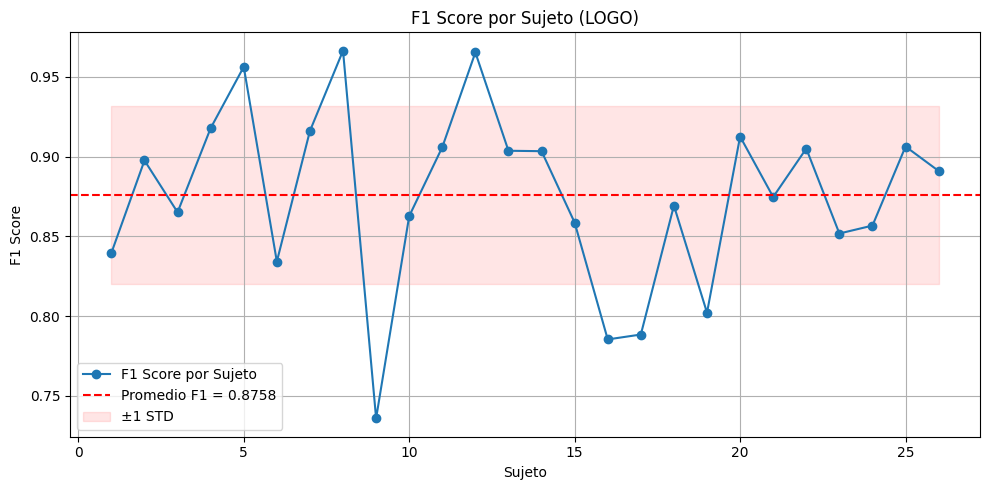


📌 Promedios generales:
Accuracy promedio: 0.8368 ± 0.0730
F1 Score promedio: 0.8758 ± 0.0558


In [15]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt

# Carpeta donde están tus modelos
MODEL_FOLDER = "modelos_cc_vs_str"
model_files = sorted([f for f in os.listdir(MODEL_FOLDER) if f.endswith(".h5")])

# Para almacenar resultados
results = []

logo = LeaveOneGroupOut()

split_num = 1
for train_idx, test_idx in logo.split(X_seq, y_seq, groups=subj_seq):
    model_path = os.path.join(MODEL_FOLDER, f"mejor_modelo_{split_num}.h5")
    if not os.path.exists(model_path):
        print(f"❌ Modelo no encontrado: {model_path}")
        split_num += 1
        continue

    print(f"✅ Evaluando modelo {split_num}")
    
    X_test = tf.cast(X_seq[test_idx], tf.float32)
    y_test = y_seq[test_idx]

    model = load_model(model_path)
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    unique, counts = np.unique(y_test, return_counts=True)
    class_dist = {f"class_{int(cls)}": int(count) for cls, count in zip(unique, counts)}

    results.append({
        "Sujeto": split_num,
        "Accuracy": acc,
        "F1 Score": f1,
        "Modelo": f"mejor_modelo_{split_num}.h5",
        **class_dist
    })

    split_num += 1

# Convertir a DataFrame
df_resultados = pd.DataFrame(results)

# -----------------------
# 🧾 Tabla resumida
# -----------------------
pd.set_option('display.float_format', lambda x: '%.4f' % x)
print("\n📊 Resultados por sujeto:")
print(df_resultados)

# -----------------------
# 📈 Gráfico resumen
# -----------------------
plt.figure(figsize=(10, 5))
plt.plot(df_resultados["Sujeto"], df_resultados["F1 Score"], marker='o', label="F1 Score por Sujeto")
plt.axhline(df_resultados["F1 Score"].mean(), color='r', linestyle='--', label=f"Promedio F1 = {df_resultados['F1 Score'].mean():.4f}")
plt.fill_between(df_resultados["Sujeto"],
                 df_resultados["F1 Score"].mean() - df_resultados["F1 Score"].std(),
                 df_resultados["F1 Score"].mean() + df_resultados["F1 Score"].std(),
                 color='r', alpha=0.1, label="±1 STD")

plt.title("F1 Score por Sujeto (LOGO)")
plt.xlabel("Sujeto")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------
# 🔢 Promedios generales
# -----------------------
print("\n📌 Promedios generales:")
print(f"Accuracy promedio: {df_resultados['Accuracy'].mean():.4f} ± {df_resultados['Accuracy'].std():.4f}")
print(f"F1 Score promedio: {df_resultados['F1 Score'].mean():.4f} ± {df_resultados['F1 Score'].std():.4f}")


In [16]:
# 📈 Análisis estadístico detallado
print("\n" + "="*60)
print("📈 ANÁLISIS ESTADÍSTICO DETALLADO")
print("="*60)

# Estadísticas por métrica
accuracy_stats = df_resultados['Accuracy'].describe()
f1_stats = df_resultados['F1 Score'].describe()

print(f"\n🎯 Estadísticas de Accuracy:")
print(f"   • Mínimo: {accuracy_stats['min']:.4f}")
print(f"   • Q1 (25%): {accuracy_stats['25%']:.4f}")
print(f"   • Mediana: {accuracy_stats['50%']:.4f}")
print(f"   • Q3 (75%): {accuracy_stats['75%']:.4f}")
print(f"   • Máximo: {accuracy_stats['max']:.4f}")
print(f"   • Desviación estándar: {accuracy_stats['std']:.4f}")

print(f"\n🎯 Estadísticas de F1 Score:")
print(f"   • Mínimo: {f1_stats['min']:.4f}")
print(f"   • Q1 (25%): {f1_stats['25%']:.4f}")
print(f"   • Mediana: {f1_stats['50%']:.4f}")
print(f"   • Q3 (75%): {f1_stats['75%']:.4f}")
print(f"   • Máximo: {f1_stats['max']:.4f}")
print(f"   • Desviación estándar: {f1_stats['std']:.4f}")

# Identificar mejores y peores sujetos
best_acc_idx = df_resultados['Accuracy'].idxmax()
worst_acc_idx = df_resultados['Accuracy'].idxmin()
best_f1_idx = df_resultados['F1 Score'].idxmax()
worst_f1_idx = df_resultados['F1 Score'].idxmin()

print(f"\n🏆 Mejores y peores resultados:")
print(f"   • Mejor Accuracy: Sujeto {df_resultados.loc[best_acc_idx, 'Sujeto']} ({df_resultados.loc[best_acc_idx, 'Accuracy']:.4f})")
print(f"   • Peor Accuracy: Sujeto {df_resultados.loc[worst_acc_idx, 'Sujeto']} ({df_resultados.loc[worst_acc_idx, 'Accuracy']:.4f})")
print(f"   • Mejor F1: Sujeto {df_resultados.loc[best_f1_idx, 'Sujeto']} ({df_resultados.loc[best_f1_idx, 'F1 Score']:.4f})")
print(f"   • Peor F1: Sujeto {df_resultados.loc[worst_f1_idx, 'Sujeto']} ({df_resultados.loc[worst_f1_idx, 'F1 Score']:.4f})")

# Confiabilidad del modelo
variability_acc = df_resultados['Accuracy'].std() / df_resultados['Accuracy'].mean()
variability_f1 = df_resultados['F1 Score'].std() / df_resultados['F1 Score'].mean()

print(f"\n📊 Consistencia del modelo (Coeficiente de Variación):")
print(f"   • Accuracy CV: {variability_acc:.4f} ({'Muy consistente' if variability_acc < 0.1 else 'Moderadamente consistente' if variability_acc < 0.2 else 'Variable'})")
print(f"   • F1 Score CV: {variability_f1:.4f} ({'Muy consistente' if variability_f1 < 0.1 else 'Moderadamente consistente' if variability_f1 < 0.2 else 'Variable'})")

# Umbral de rendimiento
good_performance_threshold = 0.8
excellent_performance_threshold = 0.9

good_acc_count = (df_resultados['Accuracy'] >= good_performance_threshold).sum()
excellent_acc_count = (df_resultados['Accuracy'] >= excellent_performance_threshold).sum()
good_f1_count = (df_resultados['F1 Score'] >= good_performance_threshold).sum()
excellent_f1_count = (df_resultados['F1 Score'] >= excellent_performance_threshold).sum()

total_subjects = len(df_resultados)

print(f"\n🎯 Distribución de rendimiento:")
print(f"   • Sujetos con Accuracy ≥ 80%: {good_acc_count}/{total_subjects} ({good_acc_count/total_subjects*100:.1f}%)")
print(f"   • Sujetos con Accuracy ≥ 90%: {excellent_acc_count}/{total_subjects} ({excellent_acc_count/total_subjects*100:.1f}%)")
print(f"   • Sujetos con F1 Score ≥ 80%: {good_f1_count}/{total_subjects} ({good_f1_count/total_subjects*100:.1f}%)")
print(f"   • Sujetos con F1 Score ≥ 90%: {excellent_f1_count}/{total_subjects} ({excellent_f1_count/total_subjects*100:.1f}%)")


📈 ANÁLISIS ESTADÍSTICO DETALLADO

🎯 Estadísticas de Accuracy:
   • Mínimo: 0.6888
   • Q1 (25%): 0.8053
   • Mediana: 0.8443
   • Q3 (75%): 0.8793
   • Máximo: 0.9562
   • Desviación estándar: 0.0730

🎯 Estadísticas de F1 Score:
   • Mínimo: 0.7359
   • Q1 (25%): 0.8530
   • Mediana: 0.8828
   • Q3 (75%): 0.9061
   • Máximo: 0.9663
   • Desviación estándar: 0.0558

🏆 Mejores y peores resultados:
   • Mejor Accuracy: Sujeto 8 (0.9562)
   • Peor Accuracy: Sujeto 9 (0.6888)
   • Mejor F1: Sujeto 8 (0.9663)
   • Peor F1: Sujeto 9 (0.7359)

📊 Consistencia del modelo (Coeficiente de Variación):
   • Accuracy CV: 0.0873 (Muy consistente)
   • F1 Score CV: 0.0637 (Muy consistente)

🎯 Distribución de rendimiento:
   • Sujetos con Accuracy ≥ 80%: 20/26 (76.9%)
   • Sujetos con Accuracy ≥ 90%: 3/26 (11.5%)
   • Sujetos con F1 Score ≥ 80%: 23/26 (88.5%)
   • Sujetos con F1 Score ≥ 90%: 11/26 (42.3%)
